<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox, which is a python toolbox for building a surrogate model.</b></div>

Nathalie BARTOLI ONERA/DTIS/M2CI - May 2021 
based on `SMT 1.0 version` 

<div class="alert alert-info fade in" id="d110">
<p>Some updates</p>
<ol> -  compare different covariance kernels for the kriging models </ol>
<ol> -  example to use Marginal Gaussian Process   </ol>    
<ol> -  example to use multiple outputs (independant outputs) </ol>
<ol> -  example to compare models using Mixture of experts technique  </ol>  
<ol> -  example to save and load models using  `pickle`  </ol>    
</div>

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: https://www.researchgate.net/profile/Mohamed_Amine_Bouhlel/publication/331976718_A_Python_surrogate_modeling_framework_with_derivatives/links/5cc3cebd299bf12097829631/A-Python-surrogate-modeling-framework-with-derivatives.pdf

Cite us:

M.-A. Bouhlel, J. T. Hwang, N. Bartoli, R. Lafage, J. Morlier, J .R.R.A Martins (2019), A Python surrogate modeling framework with derivatives, Advances in Engineering Software, 102662


<div class="alert alert-danger" >
<p> In most of the surrogate models $y\in\mathbb{R}$, so if you have multiple outputs $y\in\mathbb{R}^d$ (which are considered as independant outputs), add an external loop to buil one surrogate model per output. The correlations betweens outputs are not taken into account. Section 11 of this notebook presents an example with 2 outputs.
</div>

<div class="alert alert-warning" >
In this notebook, the database is considered to be noise-free. If you want to consider noisy data, please have a look at the dedicated notebook available within SMT. 
</div>


In [1]:
!pip install smt

# 0. Construction of the DOE points

In [2]:
from __future__ import print_function, division
import numpy as np
from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

## Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    

## Training points and validation points using a LHS algorithm

Here we outline the studied function by plotting the surface representing the function. In addition, we plot also the training points used later to build the surrogate model as well as the validation points which will be used to evaluate the quality of the surrogate model. Both the training point and validation points are generated by a LHS DOE algorithm.

<div class="alert alert-danger" >
<p> In order to have reproducibility of the tests and results, we use  the option random_state to set a seed to the random generator, so that your DOE points are always deterministic. If you don't set a seed, it is different each time.
</div>

In [3]:
########### Initialization of the problem, construction of the training and validation points

ndim = 2
ndoe = 20 #int(10*ndim)
# Define the function
fun = Rosenbrock(ndim=ndim)

# Construction of the DOE
# in order to have the always same LHS points, random_state=1
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
xt = sampling(ndoe)
# Compute the outputs
yt = fun(xt)

# Construction of the validation points
ntest = 200 #500
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
xtest = sampling(ntest)
ytest = fun(xtest)

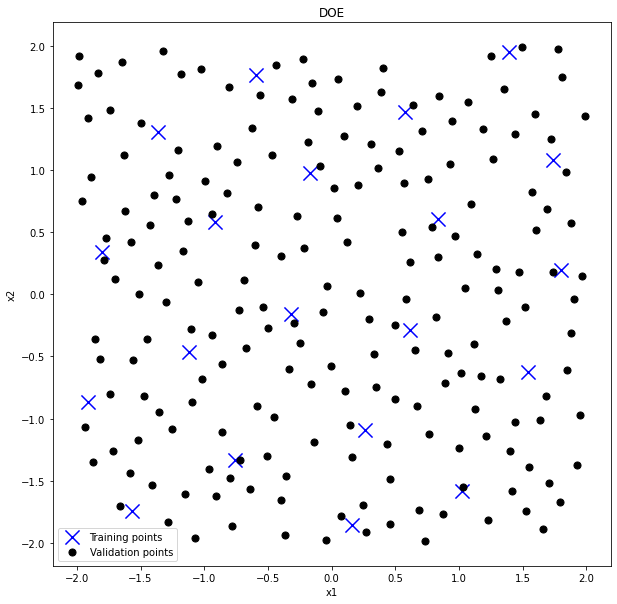

In [4]:
#To visualize the DOE points
fig = plt.figure(figsize=(10, 10))
plt.scatter(xt[:,0],xt[:,1],marker = 'x',c='b',s=200,label='Training points')
plt.scatter(xtest[:,0],xtest[:,1],marker = '.',c='k', s=200, label='Validation points')
plt.title('DOE')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

<ipython-input-5-f7befbe8f21f>:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


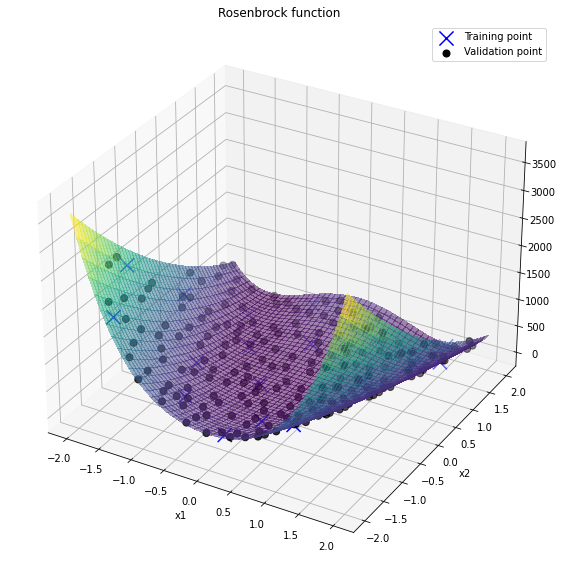

In [5]:
# To plot the Rosenbrock function
x = np.linspace(-2,2,50)
res = []
for x0 in x:
    for x1 in x:
        res.append(fun(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.viridis,
                       linewidth=0, antialiased=False,alpha=0.5)

ax.scatter(xt[:,0],xt[:,1],yt,zdir='z',marker = 'x',c='b',s=200,label='Training point')
ax.scatter(xtest[:,0],xtest[:,1],ytest,zdir='z',marker = '.',c='k',s=200,label='Validation point')

plt.title('Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

Different models will be used and compared:

- Linear Model (first order polynomial)
- Quadratic Model (second order polynomial)
- Kriging Model (also known as Gaussian Process)
- KPLS Model and KPLSK Model (useful for Kriging in high dimension)
- IDW Model (Inverse Distance Weighting)
- RBF Model (Radial Basis Function)
- RMTS Models: RMTB and RMTC (useful for low dimensional problem)

Some metrics to assess some errors are proposed at the end.

Mixture of experts technique will be used to compare different surrogate models.

# 1. Linear Model

___________________________________________________________________________
   
                                    LS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0034986
LS,  err: 0.7169114339274983


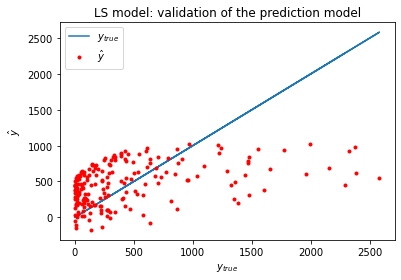

In [6]:
########### The LS model

# Initialization of the model
t = LS(print_prediction = False)

# Add the DOE
t.set_training_values(xt,yt[:,0])

# Train the model
t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('LS,  err: '+str(compute_rms_error(t,xtest,ytest)))

# Plot prediction/true values
if plot_status:

    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
        
    plt.legend(loc='upper left')
    plt.title('LS model: validation of the prediction model')

# 2. Quadratic Model

___________________________________________________________________________
   
                                    QP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0018036
QP,  err: 0.45462334576094354


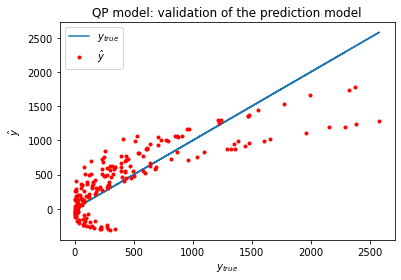

In [7]:
########### The QP model

t = QP(print_prediction = False)
t.set_training_values(xt,yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('QP,  err: '+str(compute_rms_error(t,xtest,ytest)))

# Plot prediction/true values
if plot_status:

    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
        
    plt.legend(loc='upper left')
    plt.title('QP model: validation of the prediction model')


# 3. Kriging Model

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1513255
Kriging,  err: 9.64774732068418e-05


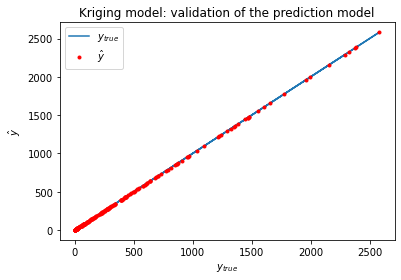

theta values [0.02404091 0.00010557]


In [8]:
########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2]*ndim,print_prediction = False)
t.set_training_values(xt,yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('Kriging,  err: '+ str(compute_rms_error(t,xtest,ytest)))
if plot_status:
    
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model')   

if plot_status:
    plt.show()

# Value of theta
print("theta values",  t.optimal_theta)

Associated to the Kriging prediction, there is the estimated variance in order to have a confidence interval.


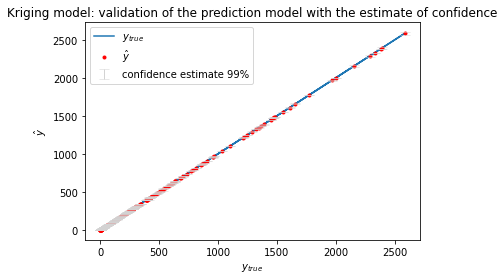

In [9]:
# estimated variance for the validation points
s2 = t.predict_variances(xtest)
#plot with the associated interval confidence
yerr= 2*3*np.sqrt(s2) #in order to use +/- 3 x standard deviation: 99% confidence interval estimation
if plot_status:
    
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
    plt.errorbar(ytest, y, yerr=np.squeeze(yerr), fmt = 'none', capsize = 5, ecolor = 'lightgray', elinewidth = 1, capthick = 0.5, label='confidence estimate 99%')
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model with the estimate of confidence')   

if plot_status:
    plt.show()


You can also have access to the kriging derivative prediction


In [10]:
# estimated derivative for the validation points
dydx1 = t.predict_derivatives(xtest, 0) #derivtive according to the x1
dydx2 = t.predict_derivatives(xtest, 1) #derivtive according to the x2

<div class="alert alert-info fade in" id="d110">
<p>The idea could be to compare different covariance kernels</p>
<ol> -  a squared exponential kernel (by default)  </ol>
<ol> -  an absolute exponential kernel   </ol>    
<ol> - some Matern Kernels (matern 32 and matern 52) </ol>
</div>

In [11]:
#squared exponential by default
t1 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp')
t1.set_training_values(xt,yt[:,0])
t1.train()
# Prediction of the validation points
y1 = t1.predict_values(xtest)

#absolute exponential
t2 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='abs_exp')
t2.set_training_values(xt,yt[:,0])
t2.train()
# Prediction of the validation points
y2 = t2.predict_values(xtest)

#matern32 
t3 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='matern32')
t3.set_training_values(xt,yt[:,0])
t3.train()
# Prediction of the validation points
y3 = t3.predict_values(xtest)

#matern52
t4 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='matern52')
t4.set_training_values(xt,yt[:,0])
t4.train()
# Prediction of the validation points
y4 = t4.predict_values(xtest)



print('\n')
print('Comparison of errors')
print('Kriging squared exponential,  err: '+ str(compute_rms_error(t1,xtest,ytest)))
print('Kriging absolute exponential,  err: '+ str(compute_rms_error(t2,xtest,ytest)))
print('Kriging matern32,  err: '+ str(compute_rms_error(t3,xtest,ytest)))
print('Kriging matern52,  err: '+ str(compute_rms_error(t4,xtest,ytest)))

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1511438
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1517487
___________________________________________________________________________
   
                                  Kriging
__________________________________________________

<div class="alert alert-info fade in" id="d110">
<p>Following the same idea, we can compare different  regression terms</p>
<ol> -  constant term  (by default)  </ol>
<ol> -  linear term  </ol>    
<ol> -  quadratic term </ol>
</div>

In [12]:
#squared exponential + constant term by default
t1 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp', poly='constant')
t1.set_training_values(xt,yt[:,0])
t1.train()
# Prediction of the validation points
y1 = t1.predict_values(xtest)

#squared exponential + linear term
t2 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp', poly='linear')
t2.set_training_values(xt,yt[:,0])
t2.train()
# Prediction of the validation points
y2 = t2.predict_values(xtest)

#squared exponential + quadratic term
t2 = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp', poly='quadratic')
t2.set_training_values(xt,yt[:,0])
t2.train()
# Prediction of the validation points
y2 = t2.predict_values(xtest)


print('\n')
print('Comparison of errors')
print('Kriging squared exponential + constant term,  err: '+ str(compute_rms_error(t1,xtest,ytest)))
print('Kriging squared exponential + linear term,  err: '+ str(compute_rms_error(t2,xtest,ytest)))
print('Kriging squared exponential + quadratic term,  err: '+ str(compute_rms_error(t3,xtest,ytest)))


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1456654
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1517565
___________________________________________________________________________
   
                                  Kriging
__________________________________________________

## Visualization 
Here we visualize the prediction using the Kriging surrogate. We can also plot the confidence interval using the estimated variance.

<ipython-input-13-722760746e21>:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


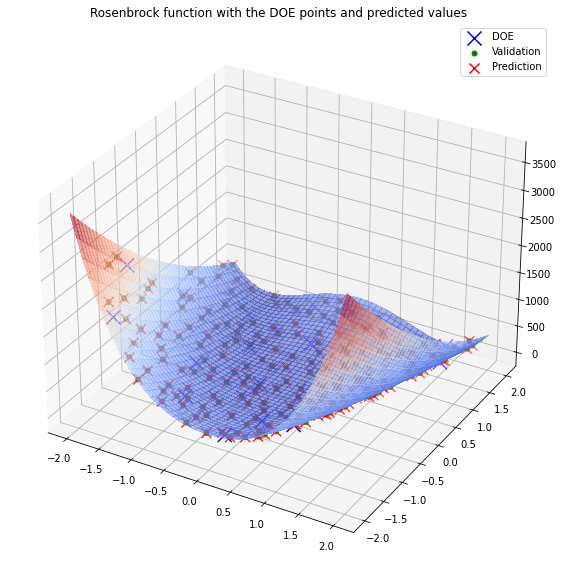

In [13]:
# Plot the surrogate model in 3D 
x = np.linspace(-2, 2, 50)
resSM = []
varSM = []
for x0 in x:
    for x1 in x:
        resSM.append(t.predict_values(np.array([[x0,x1]])))
        varSM.append(t.predict_variances(np.array([[x0,x1]])))
        
resSM = np.array(resSM)
resSM = resSM.reshape((50,50)).T
varSM = np.array(varSM)
varSM = varSM.reshape((50,50)).T                     
X,Y = np.meshgrid(x,x)


fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
ax.scatter(xt[:,0], xt[:,1], yt, zdir='z', marker='x', c='b', s=200, label='DOE')
surf = ax.plot_surface(X, Y, resSM, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
ax.scatter(xtest[:,0], xtest[:,1], ytest, zdir='z', marker='.', c='g', s=100, label='Validation')
ax.scatter(xtest[:,0], xtest[:,1], y, zdir='z', marker = 'x', c='r', s=100, label='Prediction')
plt.legend()
plt.title('Rosenbrock function with the DOE points and predicted values')

plt.show()

<ipython-input-14-d83cc3203bb2>:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


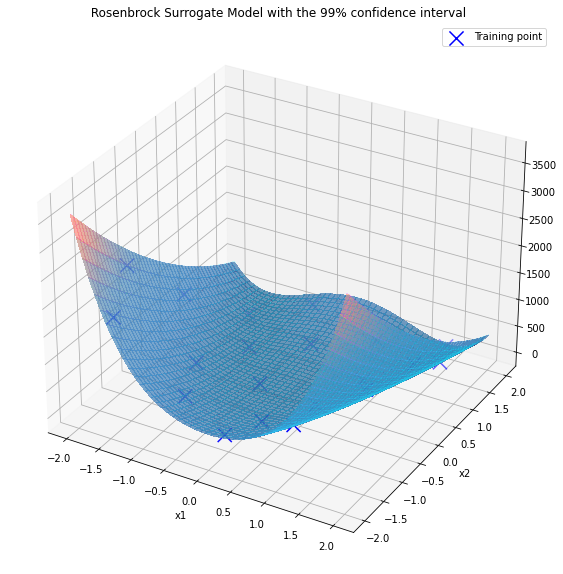

In [14]:
# Plot the surrogate with 99% confidence by using the estimated variance information
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, resSM, cmap=cm.viridis,
                       linewidth=0, antialiased=False,alpha=0.5)
surf = ax.plot_surface(X, Y, resSM+3*np.sqrt(varSM), color='r',  cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.2)
surf = ax.plot_surface(X, Y, resSM-3*np.sqrt(varSM), color='r',  cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.2)


ax.scatter(xt[:,0],xt[:,1],yt,zdir='z',marker = 'x',c='b',s=200,label='Training point')
#ax.scatter(xtest[:,0],xtest[:,1],ytest,zdir='z',marker = '.',c='k',s=200,label='Validation point')

plt.title(' Rosenbrock Surrogate Model with the 99% confidence interval ')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

<ipython-input-15-0c88d321f05d>:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
No handles with labels found to put in legend.


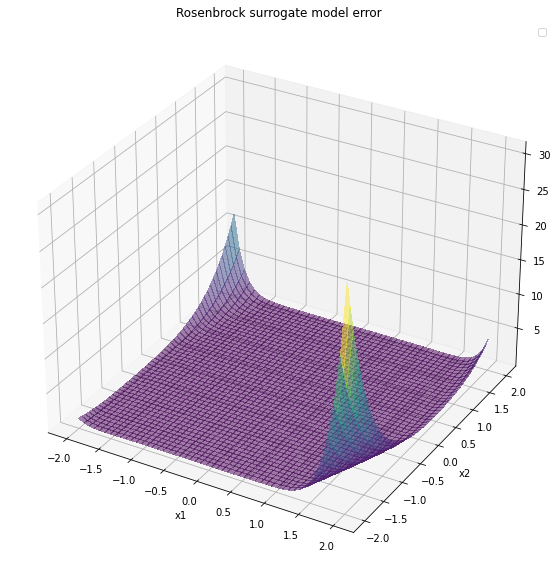

In [15]:
# Plot of the variance
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, varSM, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha=0.5)

plt.title('Rosenbrock surrogate model error')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

# 4. KPLS and KPLSK Model

Here we implement the KPLS and KLPSK models (useful for high dimensional input space, approximatively greater than 10).

<div class="alert alert-warning">
<p>Only some covariance kernels are available for these models </p>
<ol> -  a squared exponential or an absolute exponential kernel for KPLS </ol>
<ol> -  a squared exponential  kernel for KPLSK </ol>    
</div>



## 4.1 KPLS Model

___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1510994
KPLS,  err: 0.3736061564048175


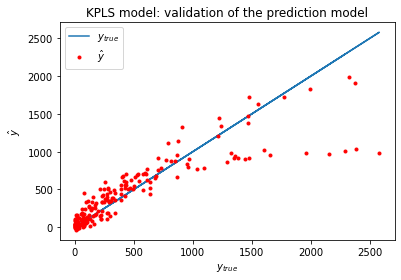

In [16]:
########### The KPLS model

# 'n_comp' and 'theta0' must be an integer in [1,ndim[ and a list of length n_comp, respectively.

t = KPLS(n_comp=2, theta0=[1e-2,1e-2], print_prediction=False, corr='abs_exp')
t.set_training_values(xt, yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('KPLS,  err: '+str(compute_rms_error(t,xtest,ytest)))

#plot prediction/true values
if plot_status:
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLS model: validation of the prediction model')

if plot_status:
    plt.show()

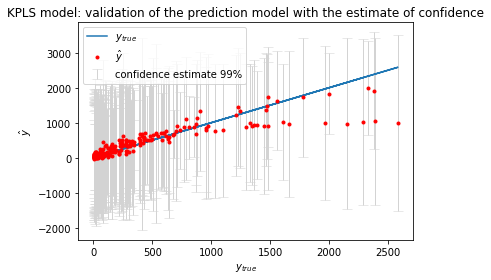

In [17]:
# estimated variance for the validation points
s2 = t.predict_variances(xtest)
#plot with the associated interval confidence
yerr= 2*3*np.sqrt(s2) #in order to use +/- 3 x standard deviation: 99% confidence interval estimation
if plot_status:
    
# Plot the function, the prediction and the 99% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
    plt.errorbar(ytest, y, yerr=np.squeeze(yerr), fmt = 'none', capsize = 5, ecolor = 'lightgray', elinewidth = 1, capthick = 0.5, label='confidence estimate 99%')
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLS model: validation of the prediction model with the estimate of confidence')   

if plot_status:
    plt.show()

___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...


/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:206: FutureWarning: As of version 0.24, n_components(3) should be in [1, n_features].n_components=2 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


   Training - done. Time (sec):  1.0524080

 --------------------------
 2 COMPONENTS FOUND OPTIMAL
 --------------------------

KPLS,  err: 0.3736061564048175


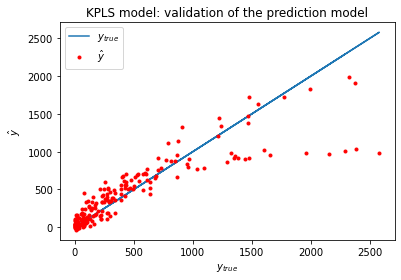

In [50]:
##Automatic selection of the number of components

# 'n_comp' and 'theta0' must be an integer in [1,ndim[ and a list of length n_comp, respectively.
# 'eval_n_comp'  must be a boolean.

t = KPLS(eval_n_comp=True, print_prediction=False, corr='abs_exp')
t.set_training_values(xt, yt[:,0])

t.train()
l = t.options["n_comp"]
print("\n --------------------------\n",l, "COMPONENTS FOUND OPTIMAL\n --------------------------\n")
# Prediction of the validation points
y = t.predict_values(xtest)
print('KPLS,  err: '+str(compute_rms_error(t,xtest,ytest)))

#plot prediction/true values
if plot_status:
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLS model: validation of the prediction model')

if plot_status:
    plt.show()

## 4.2 KPLSK Model

___________________________________________________________________________
   
                                   KPLSK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.3039234
KPLSK,  err: 9.64774732068418e-05


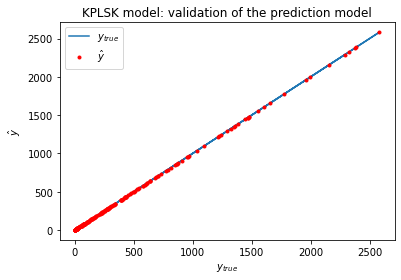

In [19]:
########### The KPLSK model

# 'n_comp' and 'theta0' must be an integer in [1,ndim[ and a list of length n_comp, respectively.

t = KPLSK(n_comp=2, theta0=[1e-2,1e-2], print_prediction=False)
t.set_training_values(xt, yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('KPLSK,  err: '+str(compute_rms_error(t,xtest,ytest)))

#plot prediction/true values
if plot_status:
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLSK model: validation of the prediction model')

if plot_status:
    plt.show()

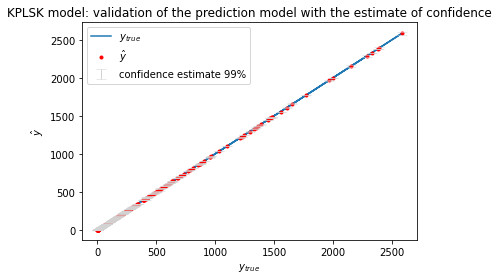

In [20]:
# estimated variance for the validation points
s2 = t.predict_variances(xtest)
#plot with the associated interval confidence
yerr= 2*3*np.sqrt(s2) #in order to use +/- 3 x standard deviation: 99% confidence interval estimation
if plot_status:
    
# Plot the function, the prediction and the 99% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
    plt.errorbar(ytest, y, yerr=np.squeeze(yerr), fmt = 'none', capsize = 5, ecolor = 'lightgray', elinewidth = 1, capthick = 0.5, label='confidence estimate 99%')
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLSK model: validation of the prediction model with the estimate of confidence')   

if plot_status:
    plt.show()

# 5. IDW Model
Here we implement the IDW model.

___________________________________________________________________________
   
                                    IDW
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0003574
IDW,  err: 0.47696357125305333


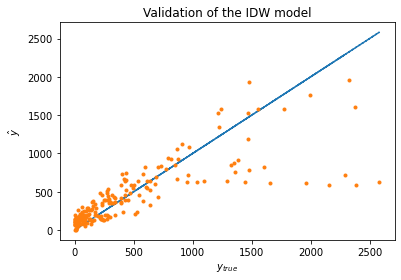

In [21]:
if compiled_available:
########### The IDW model

    t = IDW(print_prediction=False)
    t.set_training_values(xt, yt[:,0])

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('IDW,  err: '+str(compute_rms_error(t, xtest, ytest)))
    if plot_status:
        plt.figure()
        plt.plot(ytest,ytest,'-.')
        plt.plot(ytest,y,'.')
        plt.xlabel(r'$y_{true}$')
        plt.ylabel(r'$\hat{y}$')
        plt.title('Validation of the IDW model')
        plt.show()

# 6. RBF Model
Here we implement the RBF model.

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (21 x 21 mtx) ...
         Performing LU fact. (21 x 21 mtx) - done. Time (sec):  0.0001209
      Initializing linear solver - done. Time (sec):  0.0001853
      Solving linear system (col. 0) ...
         Back solving (21 x 21 mtx) ...
         Back solving (21 x 21 mtx) - done. Time (sec):  0.0000682
      Solving linear system (col. 0) - done. Time (sec):  0.0001228
   Training - done. Time (sec):  0.0007927
RBF,  err: 0.4046967225309326


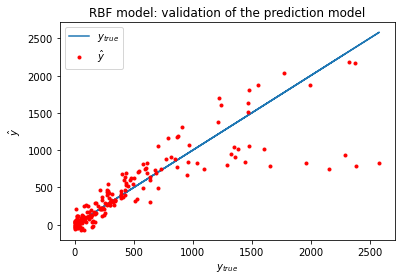

In [22]:
if compiled_available:
     ########### The RBF model

    t = RBF(print_prediction = False,poly_degree = 0)
    t.set_training_values(xt,yt[:,0])

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RBF,  err: '+str(compute_rms_error(t,xtest,ytest)))
    # Plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RBF model: validation of the prediction model')

# 7. RMTS Models

The RMTB and RMTC models are suitable for low-dimensional problems.

## 7.1 RMTB Model

___________________________________________________________________________
   
                                   RMTB
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0000045
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0012715
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0072491
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0011425
      Pre-computing matrices - done. Time (sec):  0.0101955
      Solving for degrees of freedom ...
         Solving initial startup problem (n=225) ...
            Solving for output 0 ...
       

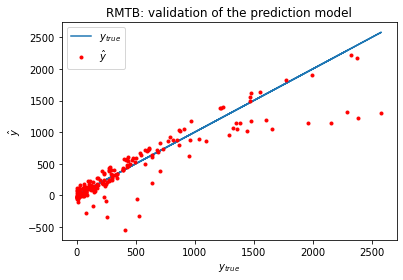

In [23]:
if compiled_available:
########### The RMTB model

    t = RMTB(xlimits=fun.xlimits, min_energy=True, nonlinear_maxiter=20, print_prediction=False)
    t.set_training_values(xt, yt[:,0])
    # Add the gradient information
#    for i in range(ndim):
#        t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)
    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RMTB,  err: '+str(compute_rms_error(t, xtest, ytest)))
    #plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RMTB: validation of the prediction model')     
    
    if plot_status:
        plt.show()

## 7.2 RMTC Model

___________________________________________________________________________
   
                                   RMTC
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0029848
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0007217
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0044708
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0015943
      Pre-computing matrices - done. Time (sec):  0.0104744
      Solving for degrees of freedom ...
         Solving initial startup problem (n=100) ...
            Solving for output 0 ...
       

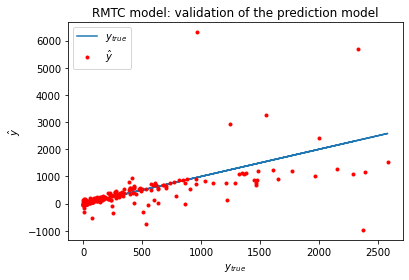

In [24]:
if compiled_available:
########### The RMTC model

    t = RMTC(xlimits=fun.xlimits, min_energy=True, nonlinear_maxiter=20, print_prediction=False)
    t.set_training_values(xt, yt[:,0])
#    # Add the gradient information
#    for i in range(ndim):
#        t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RMTC,  err: '+str(compute_rms_error(t, xtest, ytest)))
    #plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RMTC model: validation of the prediction model')
    
    if plot_status:
        plt.show()

# 8. Computation of error metrics

We compute several types of error,  
- the  mean square error
$$
\text{MSE} = \sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2
$$
- the relative error (RE in %) 
$$
\text{RE} = \frac{\sqrt{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}\right)\right)^2}}100,
$$ 
-  the Coefficient of variation or Coefficient of correlation (R2)
$$
\text{R2} = 1- \frac{{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}  \right)- \bar y \right)^2}},
$$ 
where  ${\displaystyle {\bar {y}}}$  is the mean of the observed data:
$${\bar {y}}=\frac {1}{n_{\text{test}}}\sum _{i=1}^{n_{\text{test}}}\hat{y}\left(\textbf{x}_{\text{test},i}\right)$$
An R2 of 1 indicates that the regression line perfectly fits the data.



More metrics computed in scikit-learn are given in http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics


In [25]:
from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(ytest, y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(ytest, y))

Mean squared error: 373424.37
Variance score: -0.21


# 9. Use of derivatives

Generate the data for the training and the test set

In [26]:
#Computation of the gradient for the DOE points
# Compute the gradient
for i in range(ndim):
    yd = fun(xt,kx=i)
    yt = np.concatenate((yt,yd),axis=1)

ydtest = np.zeros((ntest,ndim))
for i in range(ndim):
    ydtest[:,i] = fun(xtest,kx=i).T

# 9.1 GEKPLS model using 2 PLS components and 1 approximating point

Training phase

In [27]:
########### The GEKPLS model using 1 approximating point and 2 components 

# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values

t = GEKPLS(n_comp=2, theta0=[1e-2,1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 1,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()

___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...


/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant at iteration {k}")
/stck/psaves/miniconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:271: UserWarning: Y residual is constant at iteration 1
  warnings.warn(f"Y residual is constant

   Training - done. Time (sec):  0.4203658


Prediction phase for the function 

GEKPLS1,  err: 0.018500733292853976


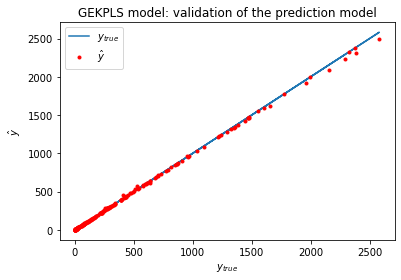

In [28]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 

Prediction phase for the derivatives

GEKPLS1, err of the 1-th derivative: 0.036209838659701656


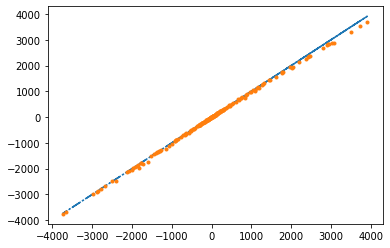

GEKPLS1, err of the 2-th derivative: 0.03638082346948957


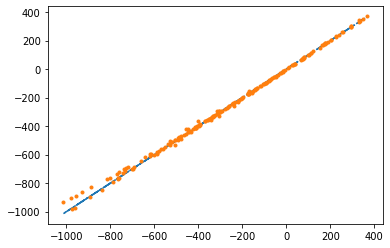

In [29]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()

# 9.2 GEKPLS model using 1 PLS component and 1 approximating point

Training phase

In [30]:

# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values


t = GEKPLS(n_comp=1, theta0=[1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 1,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()


___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.2233512


GEKPLS1,  err: 0.01975408506500632


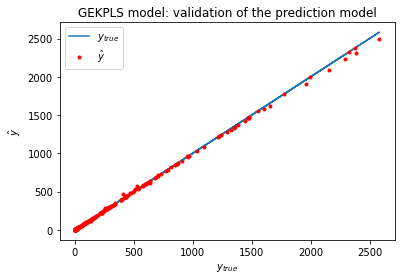

In [31]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 


Prediction phase for the derivatives

GEKPLS1, err of the 1-th derivative: 0.03858651236564411


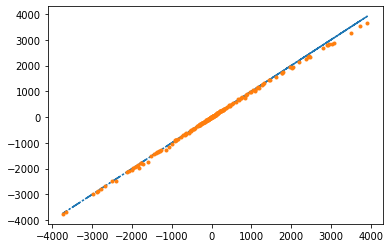

GEKPLS1, err of the 2-th derivative: 0.0389934335855385


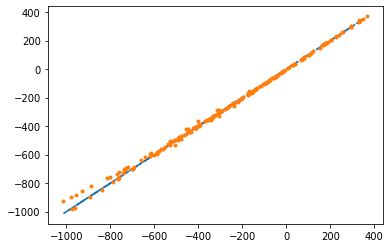

In [32]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()
        

# 9.3 GEKPLS model using 1 PLS component and 2 approximating points

Training phase

In [33]:
# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values


t = GEKPLS(n_comp=1, theta0=[1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 2,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()


___________________________________________________________________________
   
                                   KPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1275592


Prediction for the function 

GEKPLS1,  err: 0.019139743152434576


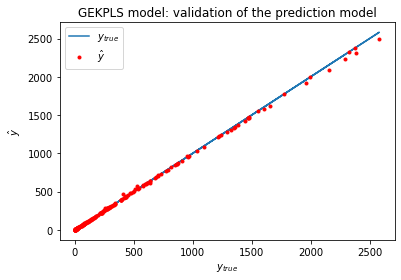

In [34]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 

Prediction for the derivatives

GEKPLS1, err of the 1-th derivative: 0.03727502624092022


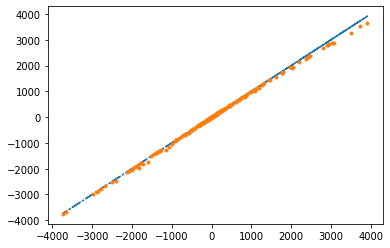

GEKPLS1, err of the 2-th derivative: 0.037503154924297726


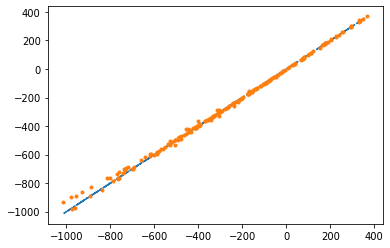

In [35]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()

# 10. Marginal Gaussian Process for high dimensional input space

To use MGP, the input space must be normalized $x \in [-1,1]^d$

___________________________________________________________________________
   
                                    MGP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.9547365
MGP,  err: 15.450745600716223


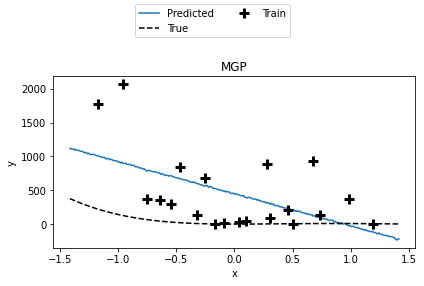

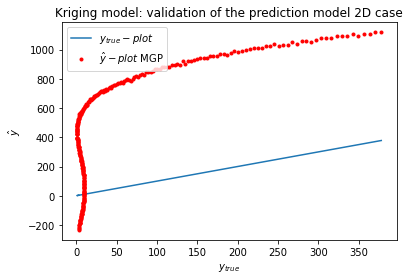

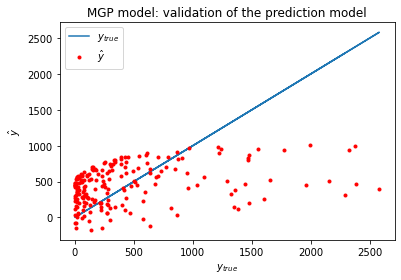

In [36]:
n_comp=1
#To  use MGP the input space must be in [-1, 1]^d, so here we divide by 2
x_train = xt/2
y_train = yt[:,0]
x_test = xtest/2

t = MGP(n_comp=n_comp, theta0=[1e-2]*n_comp*ndim, print_prediction=False)
t.set_training_values(x_train, y_train)
t.train()

# Get the transfer matrix A: u=Ax
emb = t.embedding["C"]
u_train = t.get_u_from_x(x_train)

# Compute the smallest box containing all points of A  (dimension = n_comp)
upper = np.sum(np.abs(emb), axis=0)
lower = -upper

#To have some points to validat on a plot
n_plot=300
u_plot=np.zeros((n_plot,n_comp))
for ii in range(n_comp):
    u_plot[:,ii] = np.atleast_2d(np.linspace(lower[ii], upper[ii], n_plot)) #u_plot is in dimension = n_comp

x_plot = t.get_x_from_u(u_plot) # Get corresponding points in Omega (dimension = ndim)
y_plot_true = fun(x_plot)
y_plot_pred = t.predict_values(x_plot)
sigma_MGP, sigma_KRG = t.predict_variances(x_plot, True)

y = t.predict_values(x_test)

# Prediction of the validation points
print('MGP,  err: '+str(compute_rms_error(t,xtest,ytest)))

# Plots if n_comp=1
if n_comp == 1:
    fig, ax = plt.subplots()
    ax.plot(u_plot, y_plot_pred, label="Predicted")
    ax.plot(u_plot, y_plot_true, "k--", label="True")
    ax.plot(u_train, y_train, "k+", mew=3, ms=10, label="Train")

    ax.set(xlabel="x", ylabel="y", title="MGP")
    fig.legend(loc="upper center", ncol=2)
    fig.tight_layout()
    fig.subplots_adjust(top=0.74)
    plt.show()



    #plot prediction/true values
    fig = plt.figure()
    plt.plot(y_plot_true, y_plot_true, '-', label='$y_{true}-plot$')
    plt.plot(y_plot_true, y_plot_pred, 'r.', label='$\hat{y}-plot$ MGP')

    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')

    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model 2D case')   



if plot_status:
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('MGP model: validation of the prediction model')

if plot_status:
    plt.show()
    

# 11. Multiple outputs

In cas you have multiple outputs $y \in \mathbb{R}^{n_y}$, you have to add an external loop.

Output  0
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1773040
Kriging,  err: 9.64774732068418e-05


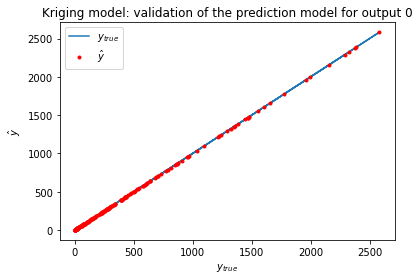

theta values for output  0  =  [0.02404091 0.00010557]
Output  1
___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1746602
Kriging,  err: 9.64774732068418e-05


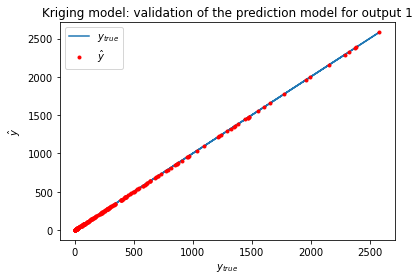

theta values for output  1  =  [0.02404091 0.00010557]


In [37]:
# Compute the ny outputs
# here y1=y2
ny = 2
yt_ny = np.zeros((np.shape(yt)[0],ny))
for ii in range(ny):
    yt_ny[:,ii]=yt[:,0]


# Construction of the validation points
ytest_ny = np.zeros((np.shape(ytest)[0],ny))
for ii in range(ny):
    ytest_ny[:,ii]=ytest[:,0]

#To build a list of models
list_t=[]
########### The Kriging model
for iny in range(ny):
    print('Output ', iny)
    # The variable 'theta0' is a list of length ndim.
    t= KRG(theta0=[1e-2]*ndim,print_prediction = False)
    t.set_training_values(xt,yt_ny[:,iny])

    t.train()
    list_t.append(t)



    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('Kriging,  err: '+ str(compute_rms_error(t,xtest,ytest_ny[:,iny])))
    if plot_status:
        
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
        fig = plt.figure()
        plt.plot(ytest_ny[:,iny], ytest_ny[:,iny], '-', label='$y_{true}$')
        plt.plot(ytest_ny[:,iny], y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('Kriging model: validation of the prediction model for output '+str(iny))   
    
    if plot_status:
        plt.show()
    
    # Value of theta
    print("theta values for output ", iny, " = ",  t.optimal_theta)

# 12. Mixture of experts to compare different surrogate models

MOE enabled experts:  ['KRG', 'LS', 'QP']
Kriging 254.62180815963336
LS 783.881353226356
QP 683.6468138523195
Best expert = Kriging
Best model found with MOE Kriging
Correlation parameter of this model: squar_exp
Regression parameter of this model: constant
MOE + 1 cluster,  err: 9.649792868099136e-05


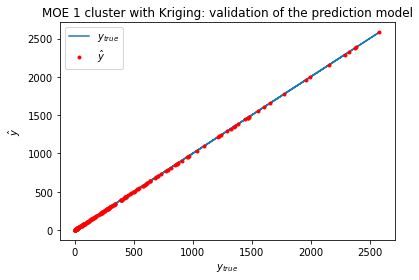

In [38]:
from smt.applications import MOE

#Only 1 cluster is considered and the surroagte models are compared on a test set from the training database
moe = MOE(n_clusters=1)
moe = MOE(n_clusters=1, xtest=xtest, ytest=ytest)

#to choose some restrictions of the available models use allow option
moe = MOE(n_clusters=1, allow=["KRG", "LS", "QP"])

print("MOE enabled experts: ", moe.enabled_experts)


moe.set_training_values(xt,yt[:,0])
moe.train()


print('Best model found with MOE', moe._experts[0].name)
if  (moe._experts[0].name=="Kriging") or (moe._experts[0].name=="KPLS")  or (moe._experts[0].name=="KPLSK") :
    print('Correlation parameter of this model:', moe._experts[0].options['corr'])
    print('Regression parameter of this model:', moe._experts[0].options['poly'])


# Prediction of the validation points
y = moe.predict_values(xtest)
print('MOE + 1 cluster,  err: '+ str(compute_rms_error(moe,xtest,ytest)))
if plot_status:
    
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('MOE 1 cluster with '+ str(moe._experts[0].name)+ ': validation of the prediction model')

if plot_status:
    plt.show()


#to add a validation set (xtest,ytest) in order to compare different surrogate models


# 13. Saving surrogate models 

As written in the documentation (https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models.html), you can save some surrogate models 

In [39]:
import pickle
#For saving models written in Python 
filename = "moe.pkl"
with open(filename, "wb") as f:
   pickle.dump(moe, f)
#For loading the model
moe_load = None
with open(filename, "rb") as f:
   moe_load= pickle.load(f)

#to use the surrogate model
y_load = moe_load.predict_values(xtest)
print(y[1:10])
print(y_load[1:10])

[[1.05708846e+02]
 [7.17689346e+01]
 [2.38912731e+03]
 [1.25059329e+01]
 [1.57147075e+00]
 [6.82353467e-01]
 [1.19829454e+01]
 [7.76740234e+01]
 [2.73422826e+02]]
[[1.05708846e+02]
 [7.17689346e+01]
 [2.38912731e+03]
 [1.25059329e+01]
 [1.57147075e+00]
 [6.82353467e-01]
 [1.19829454e+01]
 [7.76740234e+01]
 [2.73422826e+02]]
